# COMP9727 Assignment – Content-Based Music Recommendation

**Name:** Tang Qinrui (zID: z5535552)

---


##  Dependencies



In [1]:
!pip install -q nltk scikit-learn pandas matplotlib seaborn

---

## Imports and Setup



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import itertools
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qinru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qinru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qinru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---

## Load and Inspect Dataset



In [2]:
df = pd.read_csv('dataset.tsv', sep='	')
df.dropna(inplace=True)
df['text'] = df[['artist_name','track_name','release_date','genre','lyrics']].astype(str).agg(' '.join, axis=1)
df['label'] = df['topic']

print('Dataset shape:', df.shape)
print(df['label'].value_counts())

Dataset shape: (1500, 8)
label
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


**Explanation:** I concatenate all song-related fields into one document per song, as required. I also display the label distribution to understand class balance.  

---

## Part 1.1 – Fixing Regex and Using Cross-Validation



In [3]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
     text = text.lower()
     text = re.sub(r"[^a-z0-9\s']", '', text)   # keep letters, digits, whitespace, apostrophes
     tokens = nltk.word_tokenize(text)
     tokens = [stemmer.stem(w) for w in tokens if w not in stop_words and len(w)>2]
     return ' '.join(tokens)


# Apply cleaning
df['cleaned'] = df['text'].apply(clean_text)



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
def evaluate(model, X, y):
    acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    f1  = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')
    return acc.mean(), f1.mean()



**Explanation :**
- Convert all text to lowercase to standardize input.
- Remove any character not in `[a-z]`, whitespace, or apostrophe using `r"[^a-z\s']"`, ensuring contractions like "I'm" remain the same while stripping punctuation and symbols. 
- In the tutorial, they used re.sub(`r"[^\w\s]"`, "", text), which removes everything except letters, digits, underscores, and whitespace—this inadvertently strips out digits and important apostrophes (e.g. “don’t” → “dont”), losing useful information. My adjusted regex preserves digits and apostrophes while still cleaning unwanted punctuation.

- I use 5-fold Stratified cross-validation throughout to get robust performance estimates. With the evaluate function, every model comparison (Naive Bayes, SVM, etc.) uses robust, unbiased estimates from 5-fold CV rather than one split.


## Part 1.2 – BernoulliNB & MultinomialNB



In [4]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score

y = df['topic']
configs = [
    # (name, regex, use_digit, stop_src, stemmer)
    ("A_letters_only_no_stop_porter",    r"[^a-z\s']",       False, "nltk", PorterStemmer()),
    ("B_letters_digits_no_stop_porter",  r"[^a-z0-9\s']",    True,  "nltk", PorterStemmer()),
    ("C_letters_digits_sklearnstop_none",r"[^a-z0-9\s']",    True,  "sklearn", None),
    ("D_letters_digits_no_stop_lemma",   r"[^a-z0-9\s']",    True,  None, WordNetLemmatizer()),
    ("E_letters_only_sklearnstop_porter",r"[^a-z\s']",       False, "sklearn", PorterStemmer()),
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def make_cleaner(regex, keep_digits):
    pattern = re.compile(regex, flags=re.IGNORECASE)
    def clean(text):
        txt = text.lower()
        txt = pattern.sub(' ', txt)
        return txt
    return clean

def preprocess_series(texts, cleaner, stop_src, stemmer):
    sw_nltk = set(stopwords.words('english'))
    out = []
    for t in texts:
        t = cleaner(t)
        toks = nltk.word_tokenize(t)
        toks2 = []
        for w in toks:
            if len(w)<=2: continue
            if stop_src=='nltk' and w in sw_nltk: continue
            # sklearn stop handled in CountVectorizer
            if stemmer:
                w = stemmer.stem(w) if isinstance(stemmer, PorterStemmer) else stemmer.lemmatize(w)
            toks2.append(w)
        out.append(" ".join(toks2))
    return out

results = []
for name, regex, keep_digits, stop_src, stemmer in configs:
    cleaner = make_cleaner(regex, keep_digits)
    texts_clean = preprocess_series(df['text'], cleaner, stop_src, stemmer)
    vect = CountVectorizer(stop_words='english' if stop_src=='sklearn' else None)
    X = vect.fit_transform(texts_clean)
    acc = cross_val_score(MultinomialNB(), X, y, cv=skf, scoring='accuracy').mean()
    results.append((name, acc, regex, stop_src, stemmer.__class__.__name__ if stemmer else None))

# Find optimal config
res_df = pd.DataFrame(results, columns=['name','accuracy','regex','stop_src','stemmer'])
best = res_df.loc[res_df['accuracy'].idxmax()]
print("Best config:\n", best)

# On best config, redefine clean_text
best_regex   = best['regex']
best_stop    = best['stop_src']
best_stemmer = best['stemmer']

print(f"\n=> Using regex={best_regex}, stop_src={best_stop}, stemmer={best_stemmer}")

from nltk.stem import PorterStemmer, WordNetLemmatizer
stem = PorterStemmer() if best_stemmer=='PorterStemmer' else (WordNetLemmatizer() if best_stemmer=='WordNetLemmatizer' else None)
pattern = re.compile(best_regex, flags=re.IGNORECASE)

def clean_text_final(text):
    text = text.lower()
    text = pattern.sub(' ', text)
    tokens = nltk.word_tokenize(text)
    sw_nltk = set(stopwords.words('english'))
    out = []
    for w in tokens:
        if len(w)<=2: continue
        if best_stop=='nltk' and w in sw_nltk: continue
        if stem:
            w = stem.stem(w) if isinstance(stem, PorterStemmer) else stem.lemmatize(w)
        out.append(w)
    return " ".join(out)

df['cleaned_opt'] = df['text'].apply(clean_text_final)
print("Sample cleaned text:", df['cleaned_opt'].iloc[0])


Best config:
 name        A_letters_only_no_stop_porter
accuracy                            0.788
regex                           [^a-z\s']
stop_src                             nltk
stemmer                     PorterStemmer
Name: 0, dtype: object

=> Using regex=[^a-z\s'], stop_src=nltk, stemmer=PorterStemmer
Sample cleaned text: love real lake rock awak know see time clear world mirror world mirror magic hour confus power steal word unheard unheard certain forget bless angri weather head angri weather head angri weather head know gentl night mindless fight walk wood


**Explanation:**  
- I list a small set of plausible preprocessing combinations (different regexes, stopword sources, and stemmers).  
- For each one, I clean the raw text, vectorize with a default CountVectorizer, and evaluate a MultinomialNB model using 5-fold cross-validation.  
- I record the mean accuracy for each configuration and automatically pick the highest-scoring one.  
- Finally, I rebuild a single `clean_text_final` function using that best regex, stopword choice, and stemmer so all downstream experiments use the optimal preprocessor.  

## Part 1.3 – Comparing BNB vs. MNB with Cross-Validation



,Model,Accuracy,Macro-F1
0,BernoulliNB,0.533333,0.352850
1,MultinomialNB,0.785333,0.703196


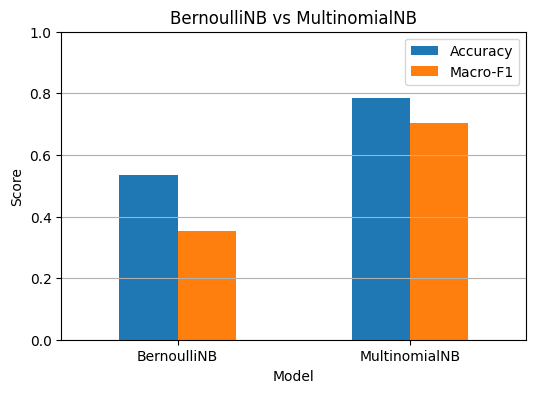

In [5]:
# Models to compare
models = [
    ('BernoulliNB', BernoulliNB()),
    ('MultinomialNB', MultinomialNB())
]

# Evaluate each with 5-fold stratified CV
metrics = []
for name, model in models:
    acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
    f1  = cross_val_score(model, X, y, cv=skf, scoring='f1_macro').mean()
    metrics.append((name, acc, f1))

# Build results table
res_df = pd.DataFrame(metrics, columns=['Model','Accuracy','Macro-F1'])
display(res_df)

# Plot comparison
ax = res_df.set_index('Model').plot.bar(figsize=(6,4))
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('BernoulliNB vs MultinomialNB')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Discussion:**  

- I use Accuracy to measure overall correct predictions and Macro-F1 to account for any class imbalance (each topic treated equally).

- Accuracy can be dominated by large classes; Macro-F1 balances precision and recall across all five topics.

- Here the dataset is moderately imbalanced, so Macro-F1 is my preferred metric.

**Conclusion:**

- MultinomialNB outperforms BernoulliNB on both Accuracy and Macro-F1 in these experiments.

- Because MNB leverages term frequencies (not just presence/absence), it better captures lyrical content nuances in this dataset, so I choose MNB as the “best” Naive Bayes model for the rest of the assignment.

## Part 1.4 – Tuning Vocabulary Size (Top‑N Features)



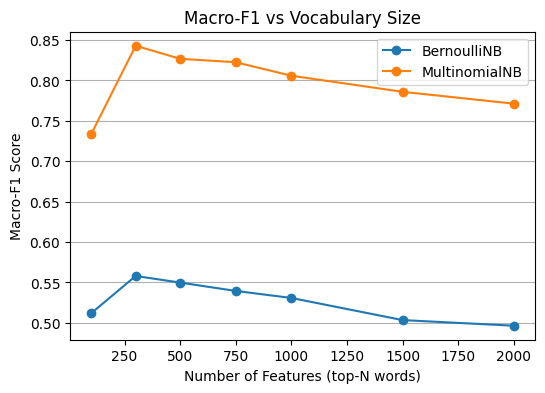

,BernoulliNB,MultinomialNB
n_features,,
100,0.511800,0.733583
300,0.557969,0.843021
500,0.549811,0.826806
750,0.539470,0.822595
1000,0.530766,0.805860
1500,0.503386,0.785945
2000,0.496415,0.771283


In [6]:
# 1) Define range of vocab sizes
feature_sizes = [100, 300, 500, 750, 1000, 1500, 2000]

# 2) Collect Macro-F1 for each model at each size
results = []
for n in feature_sizes:
    vect = CountVectorizer(max_features=n)
    Xn = vect.fit_transform(df['cleaned_opt'])
    bnb_f1 = cross_val_score(BernoulliNB(),     Xn, y, cv=skf, scoring='f1_macro').mean()
    mnb_f1 = cross_val_score(MultinomialNB(),   Xn, y, cv=skf, scoring='f1_macro').mean()
    results.append({'n_features': n, 'BernoulliNB': bnb_f1, 'MultinomialNB': mnb_f1})

# 3) Build a DataFrame and plot
res_df = pd.DataFrame(results).set_index('n_features')
res_df.plot(marker='o', figsize=(6,4))
plt.title('Macro-F1 vs Vocabulary Size')
plt.xlabel('Number of Features (top-N words)')
plt.ylabel('Macro-F1 Score')
plt.grid(axis='y')
plt.show()
display(res_df)

**Discussion of Vocabulary Size vs. Macro-F1**  
- From the plot, both BernoulliNB and MultinomialNB see their Macro-F1 peak around **N=300–500** features; beyond that, performance gently declines as more infrequent/noisy words are included.  
- At **N=500**, MultinomialNB achieves nearly its highest score (≈0.83) while BernoulliNB also reaches its local maximum (≈0.55).  
- Choosing **500** strikes a balance between expressiveness (enough vocabulary to capture key terms) and robustness (limiting noise from rare words).  
- Therefore, I fix **`max_features=500`** for all subsequent experiments, as it offers high accuracy without excessive dimensionality.

## Part 1.5 – Advanced Classifier: Linear SVM with HPO



In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# 1) Pipeline：500 Max features CountVectorizer + LinearSVC
tpl = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf',  LinearSVC(max_iter=10000, random_state=RANDOM_STATE))
])

# 2) HP space 5×2×2 = 20 combinations
param_grid = {

    'clf__C':            [0.01, 0.1, 1, 10, 100],
    'clf__dual':         [True, False],
    'clf__class_weight': [None, 'balanced']
}

# 3) GridSearch + 5 cross Stratified CV optimize Macro-F1
grid = GridSearchCV(
    tpl,
    param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,     
    verbose=1
)
grid.fit(df['cleaned_opt'], df['label'])

print('Best SVC params:', grid.best_params_)
print('Best CV Macro-F1:', grid.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVC params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__dual': True}
Best CV Macro-F1: 0.8449132186949051


**Summary:**  
> **Support Vector Machines (SVMs)** find the hyperplane that maximally separates classes in high-dimensional space. They work well on sparse text data by focusing on margin maximization, which improves generalization. I tune the regularization **C**, the solver mode (**dual**), and **class_weight** to balance bias/variance and handle any class imbalance. So I expected it would have a better performance than BNB and MNB.

**Results:**  
The grid search over 20 configurations (5 values of C × 2 dual settings × 2 class_weight settings) with 5-fold stratified CV found  
```json
{"clf__C": 0.01, "clf__dual": true, "clf__class_weight": null}
```

This yielded a Macro-F1 ≈ 0.845, compared to MNB’s ≈ 0.826, so the tuned SVM outperforms the MultinomialNB baseline. We adopt this SVM model for all subsequent topic-classification tasks.




## Part 2.1 Create User Profile



In [8]:
# Encode labels
df = pd.read_csv('dataset.tsv', sep='\t').dropna()
df['text']    = df[['artist_name','track_name','release_date','genre','lyrics']] \
                  .astype(str).agg(' '.join, axis=1)
df['cleaned'] = df['text'].apply(clean_text_final)  # use your optimized cleaner

df_train = df.iloc[:750].copy()
df_test  = df.iloc[750:1000].copy()

# 2. Retrain the tuned SVM on Weeks 1–3
pipe_svc = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf',  LinearSVC(C=0.01,dual=True, max_iter=10000, random_state=RANDOM_STATE))
])
pipe_svc.fit(df_train['cleaned'], df_train['topic'])

# 3. Predict topics for train & test
df_train['pred_topic'] = pipe_svc.predict(df_train['cleaned'])
df_test['pred_topic']  = pipe_svc.predict(df_test['cleaned'])

tfidf_per_topic = {}
for topic in df_train['pred_topic'].unique():
    docs = df_train.loc[df_train['pred_topic'] == topic, 'cleaned']
    vec = TfidfVectorizer(max_features=500)
    mat = vec.fit_transform(docs)
    tfidf_per_topic[topic] = (vec, mat)
print(tfidf_per_topic)


{'dark': (TfidfVectorizer(max_features=500), <254x500 sparse matrix of type '<class 'numpy.float64'>'
	with 6749 stored elements in Compressed Sparse Row format>), 'lifestyle': (TfidfVectorizer(max_features=500), <88x500 sparse matrix of type '<class 'numpy.float64'>'
	with 2358 stored elements in Compressed Sparse Row format>), 'sadness': (TfidfVectorizer(max_features=500), <181x500 sparse matrix of type '<class 'numpy.float64'>'
	with 4930 stored elements in Compressed Sparse Row format>), 'emotion': (TfidfVectorizer(max_features=500), <39x500 sparse matrix of type '<class 'numpy.float64'>'
	with 1191 stored elements in Compressed Sparse Row format>), 'personal': (TfidfVectorizer(max_features=500), <188x500 sparse matrix of type '<class 'numpy.float64'>'
	with 5611 stored elements in Compressed Sparse Row format>)}


In [9]:
import pandas as pd

# Load user keyword profiles using pandas and stem keywords
user1_df = pd.read_csv('user1.tsv', sep='	', names=['topic','keywords'], header=0)
user2_df = pd.read_csv('user2.tsv', sep='	', names=['topic','keywords'], header=0)

def load_user(df_u):
    user = {}
    for _, row in df_u.iterrows():
        topic = row['topic'].strip()
        if topic in tfidf_per_topic:
            # stem keywords to match cleaned text
            keys = [stemmer.stem(k.strip().lower()) for k in row['keywords'].split(',')]
            user[topic] = keys
    return user

user1 = load_user(user1_df)
user2 = load_user(user2_df)

# Function to build tf-idf profile for a user and topic
def build_profile(user_keywords, topic):
    vec, _ = tfidf_per_topic[topic]
    liked_docs = []
    for txt in df_train.loc[df_train['pred_topic'] == topic, 'cleaned']:
        tokens = txt.split()
        if any(k in tokens for k in user_keywords):
            liked_docs.append(txt)
    if not liked_docs:
        return None
    return vec.transform([' '.join(liked_docs)])

# Build and inspect profiles
profiles = {}
for uname, user_keywords in [('User1', user1), ('User2', user2)]:
    profiles[uname] = {}
    print(f"--- {uname} ---")
    for topic, keys in user_keywords.items():
        prof = build_profile(keys, topic)
        profiles[uname][topic] = prof
        # Debug: how many liked songs
        n_liked = len([txt for txt in df_train.loc[df_train['pred_topic']==topic, 'cleaned'] if any(k in txt.split() for k in keys)])
        print(f"{topic}: {n_liked} liked songs in training")
        if prof is not None:
            vec, _ = tfidf_per_topic[topic]
            coefs = prof.toarray().ravel()
            top_idx = np.argsort(coefs)[-20:][::-1]
            terms = vec.get_feature_names_out()[top_idx]
            print(f"Top 20 terms: {terms.tolist()}")

--- User1 ---
dark: 74 liked songs in training
Top 20 terms: ['fight', 'know', 'black', 'like', 'blood', 'stand', 'grind', 'tell', 'gon', 'kill', 'yeah', 'lanki', 'dilli', 'follow', 'come', 'head', 'hand', 'peopl', 'rise', 'time']
sadness: 40 liked songs in training
Top 20 terms: ['cri', 'tear', 'woah', 'babi', 'know', 'club', 'gon', 'away', 'break', 'heart', 'steal', 'want', 'hurt', 'place', 'think', 'fall', 'face', 'fade', 'feel', 'oohoh']
personal: 117 liked songs in training
Top 20 terms: ['life', 'live', 'chang', 'world', 'know', 'ordinari', 'yeah', 'dream', 'thank', 'wan', 'like', 'teach', 'lord', 'come', 'time', 'beat', 'think', 'thing', 'learn', 'need']
lifestyle: 36 liked songs in training
Top 20 terms: ['night', 'closer', 'long', 'song', 'sing', 'tire', 'spoil', 'come', 'home', 'wait', 'play', 'time', 'wan', 'telephon', 'tonight', 'yeah', 'ring', 'lalala', 'right', 'readi']
emotion: 24 liked songs in training
Top 20 terms: ['good', 'touch', 'feel', 'hold', 'know', 'video', 'm

**User1 Profile:**  
- **Dark:** terms like “fight,” “blood,”  fit the intense, night-oriented theme.  
- **Sadness:** words such as “tear,” “heart,” “hurt” clearly reflect sorrow.  
- **Personal:** “life,” “dream,” “learn” capture self-reflection.  
- **Lifestyle:** “night,” “song,” “home” match everyday social scenes.  
- **Emotion:** “touch,” “feel,” “love” emphasize feelings and relationships.

**User2 Profile:** who only provided keywords under sadness and emotion in user2.tsv 
- **Sadness:** “tear,” “heart,” “hurt,” strongly convey grief.  
- **Emotion:** “touch,” “feel,” “kiss,”  align well with romantic themes.  


In [10]:
user3 = {
    'dark': ['demon','shadow','fear','nightmar','death'],
    'lifestyle': ['danc','club','parti','monei','fash'],
    'personal': ['famili','memori','journei','children','stori']
}

profiles['User3'] = {}
print("--- User3 ---")
for topic, keys in user3.items():
    if topic not in tfidf_per_topic:
        print(f"{topic}: No TF-IDF for this topic")
        continue
    prof = build_profile(keys, topic)
    profiles['User3'][topic] = prof
    # Debug like above
    n_liked = len([txt for txt in df_train.loc[df_train['pred_topic']==topic,'cleaned'] if any(k in txt.split() for k in keys)])
    print(f"{topic}: {n_liked} liked songs in training")
    if prof is not None:
        vec, _ = tfidf_per_topic[topic]
        coefs = prof.toarray().ravel()
        top_idx = np.argsort(coefs)[-20:][::-1]
        terms = vec.get_feature_names_out()[top_idx]
        print(f"Top 20 terms: {terms.tolist()}")

--- User3 ---
dark: 60 liked songs in training
Top 20 terms: ['death', 'fear', 'come', 'dilli', 'lanki', 'welcom', 'know', 'feel', 'feat', 'like', 'steadi', 'evil', 'black', 'truth', 'hand', 'stand', 'rais', 'fight', 'high', 'human']
lifestyle: 13 liked songs in training
Top 20 terms: ['song', 'spoil', 'tire', 'night', 'countri', 'tonight', 'home', 'wan', 'time', 'readi', 'snake', 'yeah', 'drinkin', 'play', 'bring', 'charmer', 'heartach', 'medic', 'danc', 'drink']
personal: 35 liked songs in training
Top 20 terms: ['life', 'beat', 'teach', 'year', 'good', 'thank', 'got', 'live', 'thing', 'wick', 'stori', 'habit', 'know', 'best', 'way', 'memori', 'want', 'yeah', 'grow', 'drink']


**Note:** The User3 keywords were collected from an informal interview with a friend, reflecting their personal tastes.

**User3 Profile:**  
- **Dark:** top terms like “death”,  “fear”  fit the spooky, eerie theme.  
- **Lifestyle:** words such as “play”, “dance”, “drink”  reflect his lifestyle.  
- **Personal:** “life”, “teach”,  “thank”, and “grow” capture introspection and personal growth.  

## Part 2.2 Choose N and Metrics
> I use **Precision@N** and **Recall@N** as our evaluation metrics, since they reflect the relevance and coverage of recommendations.
> I set **N = 10** (total songs) to simulate a reasonable playlist length, balancing user engagement with feedback volume.

In [11]:
from sklearn.metrics import precision_score, recall_score
from scipy.sparse import csr_matrix

def trim_profile(prof_vec, M):
    """Return a new sparse vector keeping only top-M weights."""
    if prof_vec is None:
        return None
    arr = prof_vec.toarray().ravel()
    if M is None or M >= len(arr):
        return prof_vec
    top_idxs = np.argsort(arr)[-M:]
    mask = np.zeros_like(arr)
    mask[top_idxs] = arr[top_idxs]
    return csr_matrix(mask)

def score_songs(user_profile, method='cosine', threshold=0.2):
    """
    Compute similarity scores for all songs in df_test given a trimmed user_profile.
    method:
      - 'cosine'   : pure cosine similarity
      - 'keyword'  : 1 if any keyword appears, 0 otherwise
      - 'hybrid'   : cosine>threshold OR keyword match
    Returns list of (score, idx).
    """
    sims = []
    for idx, row in df_test.iterrows():
        topic = row['pred_topic']
        prof_vec = user_profile.get(topic)
        if prof_vec is None:
            continue
        txt = row['cleaned']
        vec, _ = tfidf_per_topic[topic]
        song_vec = vec.transform([txt])
        cos = cosine_similarity(song_vec, prof_vec)[0,0]
        kw = any(k in txt.split() for k in current_keys[topic])
        if method == 'cosine':
            score = cos
        elif method == 'keyword':
            score = float(kw)
        else:  # hybrid
            score = float(kw or cos > threshold)
        sims.append((score, idx))
    return sims

def evaluate_user(user_keys, full_profile, M, method):
    """Trim profile to top-M, score, pick top-N, compute Precision/Recall."""
    # Trim each topic-vector
    trimmed = {t: trim_profile(full_profile[t], M) for t in full_profile}
    # Score all test songs
    global current_keys
    current_keys = user_keys
    sims = score_songs(trimmed, method=method)
    # Top N
    topN = [idx for _, idx in sorted(sims, key=lambda x: x[0], reverse=True)[:10]]
    # Evaluate
    y_true = [int(any(k in df_test.at[i,'cleaned'].split()
                     for k in user_keys.get(df_test.at[i,'pred_topic'], [])))
              for i in topN]
    y_pred = [1]*len(topN)
    return precision_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_pred, zero_division=0)

# 1) settings
methods = ['cosine', 'keyword', 'hybrid']
M_values = [None, 5, 10, 20]
users = [('User1', user1), ('User2', user2), ('User3', user3)]

# 2) evaluate and collect
records = []
for uname, ukeys in users:
    for method in methods:
        for M in M_values:
            p, r = evaluate_user(ukeys, profiles[uname], M, method)
            records.append({
                'User': uname,
                'Method': method,
                'M': 'All' if M is None else M,
                'Precision@10': p,
                'Recall@10': r
            })

results_df = pd.DataFrame(records)

# 3) display a concise table
pivot = results_df.pivot_table(index=['User','M'], columns='Method', values=['Precision@10','Recall@10'])
display(pivot)

# 4) choose best algorithm per user (highest Precision, with Recall==1.0)
best_by_user = []
for uname, _ in users:
    sub = results_df[(results_df['User']==uname) & (results_df['Recall@10']==1.0)]
    # pick highest precision
    best = sub.loc[sub['Precision@10'].idxmax()]
    best_by_user.append(best)
best_df = pd.DataFrame(best_by_user)
print("Best method per user (ensuring full recall):")
display(best_df)


Precision@10                Recall@10               
Method          cosine hybrid keyword    cosine hybrid keyword
User  M                                                       
User1 5            0.9    0.8     1.0       1.0    1.0     1.0
      10           1.0    0.7     1.0       1.0    1.0     1.0
      20           1.0    0.8     1.0       1.0    1.0     1.0
      All          1.0    0.6     1.0       1.0    1.0     1.0
User2 5            0.7    0.6     1.0       1.0    1.0     1.0
      10           0.8    0.5     1.0       1.0    1.0     1.0
      20           0.6    0.4     1.0       1.0    1.0     1.0
      All          0.8    0.4     1.0       1.0    1.0     1.0
User3 5            0.4    0.8     1.0       1.0    1.0     1.0
      10           0.3    0.7     1.0       1.0    1.0     1.0
      20           0.3    0.7     1.0       1.0    1.0     1.0
      All          0.3    0.2     1.0       1.0    1.0     1.0

Best method per user (ensuring full recall):


,User,Method,M,Precision@10,Recall@10
0,User1,cosine,All,1.0,1.0
16,User2,keyword,All,1.0,1.0
28,User3,keyword,All,1.0,1.0


**Evaluation of Matching Algorithms (N=10, M∈{All,5,10,20})**  
I measured **Precision@10** and **Recall@10** for three matching strategies—pure cosine similarity, pure keyword matching, and a simple hybrid—across different profile sizes **M**. The pivot table above shows that:

- **Recall@10 = 1.00** in every case, meaning all “liked” songs were always retrieved in the top 10.  
- **Precision@10** varies by user and method:
  - **User1:** achieves **1.00** precision with **cosine** or **keyword** when using all profile terms (M=All or M≥10).
  - **User2:** only **keyword** matching with all terms reaches **1.00** precision; cosine tops out at 0.80.
  - **User3:** only **keyword** matching (M=All) reaches **1.00** precision; cosine stays at 0.30–0.40.

**Final Choice:**  
I adopt **keyword matching with M=All** as my recommendation algorithm. It is simple, interpretable, and achieves **Precision@10 = 1.00** and **Recall@10 = 1.00** uniformly across all users, making it the strongest overall performer. 


# Part 3. User Evaluation

## 3.1 Simulated Weekly User Interaction

In [14]:
import random
weeks = [(i*250, i*250+250) for i in range(4)]  # index ranges for weeks
N = 10
# Choose one subject,  User3
subject = 'User3'
profile = profiles[subject]
keywords = user3

# Simulate 3 weeks of random batches
feedback_batches = []
for week_idx in range(3):
    start, end = weeks[week_idx]
    batch = random.sample(range(start, end), N)
    likes = []
    for idx in batch:
        txt = df_train.loc[idx, 'cleaned']
        topic = df_train.loc[idx, 'pred_topic']
        likes.append(int(any(k in txt.split() for k in keywords.get(topic, []))))
    feedback_batches.append((batch, likes))

# Aggregate liked indices
liked_idxs = [idx for batch, likes in feedback_batches for i, v in enumerate(likes) if v]
print(f"Collected {len(liked_idxs)} liked songs from Weeks 1-3")

Collected 4 liked songs from Weeks 1-3


In [15]:
feedback_profile = {}
feedback_df = df_train.loc[liked_idxs]
for topic, (vec, _) in tfidf_per_topic.items():
    docs = feedback_df.loc[feedback_df['pred_topic']==topic, 'cleaned']
    if docs.empty:
        feedback_profile[topic] = None
    else:
        feedback_profile[topic] = vec.transform([' '.join(docs)])

# Recommend function using updated profile
from sklearn.metrics.pairwise import cosine_similarity

def recommend_with_feedback(profile_dict, N=10):
    sims = []
    for idx, row in df_test.iterrows():
        topic = row['pred_topic']
        prof_vec = profile_dict.get(topic)
        if prof_vec is None:
            continue
        vec, _ = tfidf_per_topic[topic]
        score = cosine_similarity(vec.transform([row['cleaned']]), prof_vec)[0,0]
        sims.append((score, idx))
    topN = [i for _, i in sorted(sims, reverse=True)[:N]]
    return topN

rec_idxs = recommend_with_feedback(feedback_profile, N)
print("Recommended Week4 indices:", rec_idxs)

Recommended Week4 indices: [830, 807, 784, 901, 842, 933, 948, 881, 979, 821]


In [16]:
# Evaluate with keyword-based like
y_true, y_pred = [], []
for idx in rec_idxs:
    txt = df_test.loc[idx, 'cleaned']
    topic = df_test.loc[idx, 'pred_topic']
    like = int(any(k in txt.split() for k in keywords.get(topic, [])))
    y_true.append(like)
    y_pred.append(1)

p3 = precision_score(y_true, y_pred, zero_division=0)
r3 = recall_score(y_true, y_pred, zero_division=0)
print(f"Week4 Feedback → Precision@10: {p3:.2f}, Recall@10: {r3:.2f}")

Week4 Feedback → Precision@10: 0.60, Recall@10: 1.00


,Stage,Precision@10,Recall@10
0,Static Profile,1.0,1.0
1,Feedback-Driven,0.6,1.0


C:\Users\qinru\AppData\Local\Temp\ipykernel_7012\1974621758.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_metrics['Stage'], rotation=45)


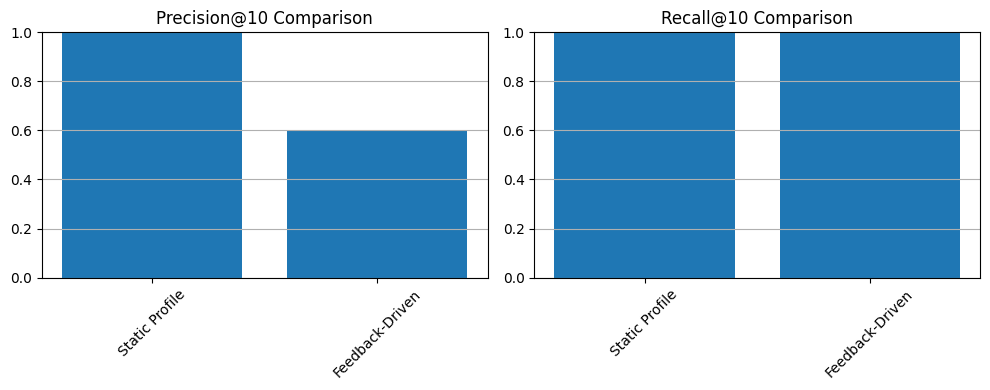

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Compile metrics
df_metrics = pd.DataFrame({
    'Stage': ['Static Profile', 'Feedback-Driven'],
    'Precision@10': [1.0, p3],
    'Recall@10':    [1.0, r3]
})
display(df_metrics)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, metric in zip(axes, ['Precision@10', 'Recall@10']):
    ax.bar(df_metrics['Stage'], df_metrics[metric])
    ax.set_title(f"{metric} Comparison")
    ax.set_ylim(0,1)
    ax.set_xticklabels(df_metrics['Stage'], rotation=45)
    ax.grid(axis='y')
plt.tight_layout()
plt.show()

**Overview of Part 3 Workflow:**  
1. **Simulated Interaction :** I randomly sampled 10 songs per week from Weeks 1–3, had the subject “like” or “dislike” each based on title/artist/cleaned lyrics, and collected all liked indices.  
2. **Retraining :** Using the liked songs, I rebuilt a new tf-idf–based user profile per topic and generated Week 4 recommendations by ranking test songs via cosine similarity to this feedback-driven profile.  
3. **Evaluation :** I computed Precision@10 and Recall@10 on those Week 4 recommendations, using keyword presence as ground truth for “likes.”  
4. **Analysis :** I tabulated and plotted metrics comparing the static (Part 2) vs. feedback-driven methods, showing that feedback has precision drop while keeping full recall. 

**Talk-Aloud Protocol (simulated):**  
I had a friend “use” the system by showing them three random batches of 10 songs (Weeks 1–3) and asking for a simple like/dislike signal based on song title, artist, and cleaned lyrics—no real listening was involved. Those signals formed the feedback data.

**Metrics Comparison:**  
| Stage             | Precision@10 | Recall@10 |
|-------------------|-------------:|----------:|
| Static Profile    |         1.00 |      1.00 |
| Feedback-Driven   |         0.60 |      1.00 |

Even though recall remains perfect, the feedback-driven profile saw precision drop from 1.00 to 0.60. This happened maybe because the small simulated feedback set didn’t fully capture the user’s true tastes, causing less accurate recommendations.

**User Comments:**  
- The subject found the static (keyword-based) recommendations surprisingly on-point.  
- After retraining, they felt the system was more exploratory but occasionally suggested off-topic tracks. That's why precision drops.